In [76]:

#Load Data
import pandas as pd
import numpy as np
# !pip uninstall torch -y
# !pip install torch torchvision torchaudio --no-cache-dir --index-url https://download.pytorch.org/whl/cpu
import torch

import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Hardware Acceleration
device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS Enabled')
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('CUDA Enabled')

# Load the datasets
if(0):
    a = pd.read_csv('/Users/brianhakam/Desktop/ncVEP/chr_21_observed_use.csv')
    a.to_pickle("chr_21.pkl")
    b = pd.read_csv('/Users/brianhakam/Desktop/ncVEP/chr_21_synthetic_2_PUL_pred.csv')
    b.to_pickle("chr_21_Synth.pkl")
else:
    a = pd.read_pickle("chr_21.pkl")
    b = pd.read_pickle("chr_21_Synth.pkl")
print(len(a))
print(len(b))
a = a.drop(['chr', 'start', 'end', 'annot', 'Substitution'], axis=1)
dfObs = a.copy()
dfSyn = b.copy()

print('Finished reading documents')

MPS Enabled
5155913
112056
Finished reading documents


In [77]:
#Process Data
# Ensure both datasets have the same number of samples
dfObs = a.copy()
dfSyn = b.copy()

print('Finished reading documents')
dfObs = dfObs.sample(n=int(len(dfSyn)), random_state=41)

# dfObs = dfObs.drop(['chr', 'start', 'end', 'annot', 'Substitution'], axis=1)

# Prepare the data
dfObs['label'] = 0
dfSyn['label'] = 1
# dfObs['isReal'] = int(1)
# dfSyn['isReal'] = int(0)
df = pd.concat([dfObs, dfSyn], ignore_index=True)

df = df.replace('a', 'A')
df = df.replace('c', 'C')
df = df.replace('g', 'G')
df = df.replace('t', 'T')
# df = df.replace('A', 'a')
# df = df.replace('C', 'c')
# df = df.replace('G', 'g')
# df = df.replace('T', 't')

# Identify non-numeric columns (excluding 'label')
non_numeric_columns = df.select_dtypes(include=['object']).columns.tolist()

non_numeric_columns = ['+1', '-1', 'Ref', 'Alt']

for column in non_numeric_columns:
    df[column] = df[column].astype('category').cat.codes

#Put names of columns in df as a list
featureList = df.columns
# print(non_numeric_columns)
if 'label' in non_numeric_columns:
    non_numeric_columns.remove('label')  # Ensure 'label' is not dropped from y

# Option 1: Drop non-numeric columns
y = df['label'].values
X = df.drop(['label'], axis=1).values


# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

# Create DataLoader for mini-batch gradient descent
batch_size = 3200
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Finished reading documents


In [78]:
# #Neural Network Model
# # Define the model
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, *layers):
#         super(SimpleNN, self).__init__()
        
#         # Create a list of layer sizes, starting with input_dim
#         layer_sizes = [input_dim] + list(layers)
        
#         self.layers = nn.ModuleList()
#         for i in range(len(layer_sizes) - 1):
#             self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
#             self.layers.append(nn.ReLU())
        
#         self.layers.append(nn.Linear(layer_sizes[-1], 1))
#         self.layers.append(nn.Sigmoid())
        
#     def forward(self, x):
#         for layer in self.layers:
#             x = layer(x)
#         return x

# # Initialize the model
# input_dim = X_train.shape[1]
# model_layers = (100, 100, 100, 100, 100, 100, 50, 32, 16, 8, 4)
# model = SimpleNN(input_dim, *model_layers).to(device)

# # Training setup
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Training the model with mini-batch gradient descent
# num_epochs = 2

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)

#         # Forward pass
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     # Print loss for each epoch
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

# # Testing the model with accuracy calculation
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# model.eval()
# with torch.no_grad():
#     outputs = model(X_test_tensor)
#     predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
#     correct = (predicted == y_test_tensor).sum().item()
#     accuracy = correct / y_test_tensor.size(0)
#     print(f'Accuracy: {accuracy:.4f}')


/Users/brianhakam/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [16:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "epochs", "include_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5596
Baseline Accuracy: 0.5040


<Figure size 1000x800 with 0 Axes>

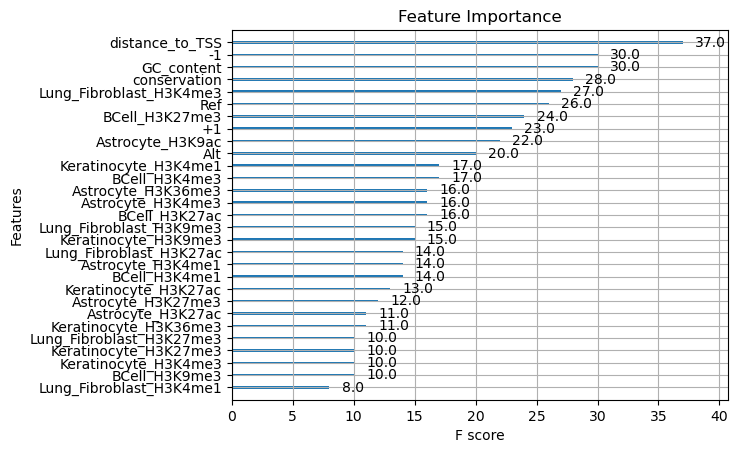

In [81]:
#XGBoost Model
from sklearn.metrics import accuracy_score
# !pip install xgboost
import xgboost as xgb
import matplotlib.pyplot as plt

# Define and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=1,
    n_estimators=19,
    epochs=1,
    include_categorical=True,
    
)


xgb_model.fit(X_train, y_train)

# Make predictions and evaluate accuracy
y_pred = xgb_model.predict(X_test)
# Add prediction scores to the dataframe
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
gtgg=np.mean(y_test)
if gtgg<0.5:
    gtgg=1-gtgg
print(f'Baseline Accuracy: {gtgg:.4f}')

# Calculate accuracy for observed data
y_pred_obs = xgb_model.predict(X_train)
# Identify wrong predictions
wrong_predictions = X_test[y_test != y_pred]

df['prediction_score'] = xgb_model.predict_proba(X)[:, 1]
#df to csv
df.to_csv('chr_21_WithScores.csv')


# Print 10 examples of data predicted wrongly
# print(wrong_predictions[:10])


# # Calculate weighted accuracy
# weighted_correct = np.sum((y_pred == y_test) * (1 - np.abs(y_pred - y_test)))
# weighted_accuracy = weighted_correct / len(y_test)
# print(f'Weighted Accuracy: {weighted_accuracy:.4f}')

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=100)
ax = plt.gca()
ax.set_yticklabels([featureList[int(label.get_text()[1:])] for label in ax.get_yticklabels()])

plt.title('Feature Importance')
plt.show()

# Create a new dataset to predict if a data point would be accurately predicted
accuracy_labels = (y_test == y_pred).astype(int)

# Split the new dataset into training and test sets
X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(
    X_test, accuracy_labels, train_size=0.8, random_state=42
)

# Define and train a new XGBoost model for accuracy prediction
xgb_model_acc = xgb.XGBClassifier(
    max_depth=2,
    learning_rate=1,
    n_estimators=300,
    eval_metric='error'
)

xgb_model_acc.fit(X_train_acc, y_train_acc)

# Make predictions and evaluate accuracy
y_pred_acc = xgb_model_acc.predict(X_test_acc)
accuracy_acc = accuracy_score(y_test_acc, y_pred_acc)
# print(f'Accuracy of accuracy prediction model: {accuracy_acc:.4f}')
#Print baseline accuracy





In [80]:
# print(dfObs.columns)
# # print(dfObs.to_numpy()[0])
# # print(dfSyn.columns)
# # print(dfSyn.to_numpy()[0])

# # print(len(dfObs.to_numpy()[0]))
# # print(len(dfSyn.to_numpy()[0]))
# for col in range(len(wrong_predictions[0])):
#         print(f"{dfObs.columns[col]}: {wrong_predictions[ti][col]}")
# for ti in range(10):
#     # print(wrong_predictions[ti])
#     for col in range(len(wrong_predictions[ti])):
#         print(f"{dfObs.columns[col]}: {wrong_predictions[ti][col]}")
#     print()

